In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from scipy.stats import (
    norm, binom, expon, t, chi2, pareto, ttest_1samp, ttest_ind, sem
)
import scipy.stats as stats
from statsmodels.stats.api import CompareMeans, DescrStatsW
from statsmodels.stats.proportion import proportion_confint
from seaborn import distplot
from matplotlib import pyplot
import seaborn
import random

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lending-club/rejected_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018Q4.csv.gz
/kaggle/input/lending-club/accepted_2007_to_2018q4.csv/accepted_2007_to_2018Q4.csv
/kaggle/input/lending-club/rejected_2007_to_2018q4.csv/rejected_2007_to_2018Q4.csv
/kaggle/input/lendingclubdata/LendingClub_data.csv


# Загрузка датасета и предобработка данных

В качестве датасета был использован набор All Lending Club loan data, выложенный на платформе Kaggle. Датасет представляет из себя набор табличных данных о заёмщиках физ.лицах, оставлявших заявку на сайте американской кредитной организации Lending Club.


In [2]:
data = pd.read_csv('/kaggle/input/lendingclubdata/LendingClub_data.csv')
data.head()

,loan_amnt,group
0,31000.0,test
1,28000.0,control
2,17000.0,test
3,5000.0,control
4,31000.0,test


# А/Б тест. Постановка и проверка гипотез на исторических данных 

Представим что в декабре 2018 г. Lending Club провели A/Б-тест
Гипотеза была следующая - введение новых условий кредитования увеличит среднюю сумму займа для заёмщиков из штата Калифорния. Тестовой группе были предложены сдеюущие условия: первые 3 месяца после даты открытия кредита заёмщик платит только начисляемые проценты по кредиту. Соотвественно контрольная группа не получала предложения с подобными условиями.

H0: E(control) = E(test)  
H1: E(control) < E(test)

In [3]:
data.group.value_counts()

group
control    2268
test       2200
Name: count, dtype: int64

In [4]:
# Делим данные на контрольную и тестовую выборки на основе меток в признаке "group"
control = data.query('group == "control"').loan_amnt
test = data.query('group == "test"').loan_amnt

In [5]:
# Обозначим уровень значимости в нашем эксперименте и вероятность ошибки II рода
alpha = 0.05
beta = 1 - 0.8

In [6]:
# Проверка MDE
N = len(data)
S2 = np.var(data['loan_amnt'])
beta = 1 - 0.8

MDE = (norm().ppf(1-alpha) + norm().ppf(1 - beta)) * np.sqrt(S2/N)
print(f"MDE при N={N}: {MDE}")

MDE при N=4468: 383.5250166168795


Мы можем рассчитывать на обнаружение разницы в 383 ед. при заданном уровне значимости, мощности и размере выборки

<Axes: >

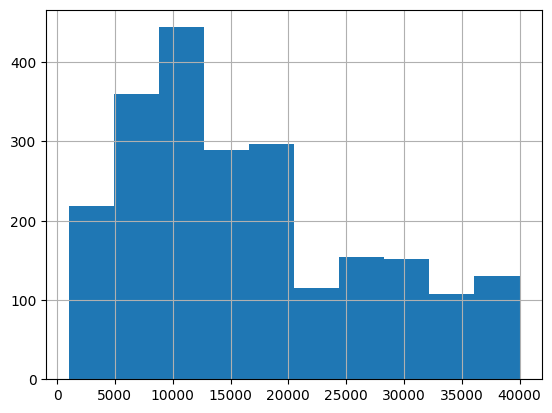

In [18]:
control.hist()

<Axes: >

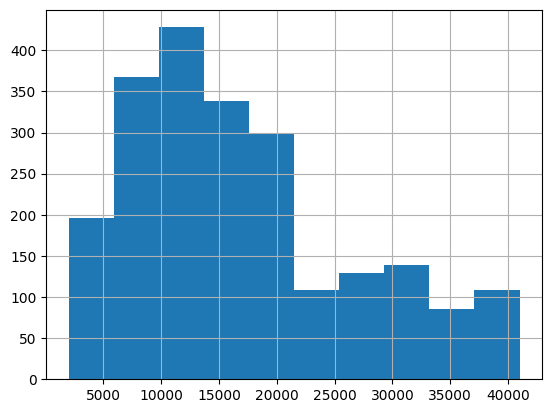

In [19]:
test.hist()

Гистограммы распрделений тестовой и контрольной выборки показывают, что наши данные распределены не нормально, проверить это мы сможем с использованием критерия Шапиро-Уилка.  
В данном случае H0 - устанавливет, что исследуемая выборка взята из нормального распредленной генеральной совокупности. Соответственно H1 означает что выборка не из нормального распределения.

In [6]:
p_value_test = stats.shapiro(test)[1]
print(f'Test p_value {p_value_test} and result {p_value_test < alpha}')
p_value_control = stats.shapiro(control)[1]
print(f'Control p_value {p_value_control} and result {p_value_control < alpha}')

Test p_value 3.329595459947071e-30 and result True
Control p_value 5.1445684236901334e-31 and result True


Проверка показала что, p-value меньше уровня значимости (0.05), поэтому мы остановимся на том, что выборки теста и контроля распределены не по нормальному закону. От распределения и размера выборки будет зависеть выбор критерия для оценки разницы между средей суммой займа.  

В вопросе применения T-теста для ненормальных выборок существует два мнения: 1) Использовать этот критерий для ненормальных выборок любого размера нельзя; 2) Использовать критерий можно для достаточно больших выборок (>20-30) из любого распределения, важно лишь распределение среднего из выборки - если распределение выборочного среднего является нормальным, то использовать T-тест можно. 

Проверим распределение выборочных средних, сгенерировав распределение с помощью метода бутстрап

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


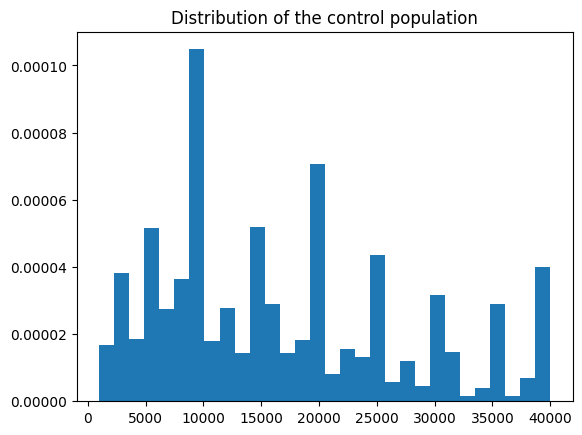

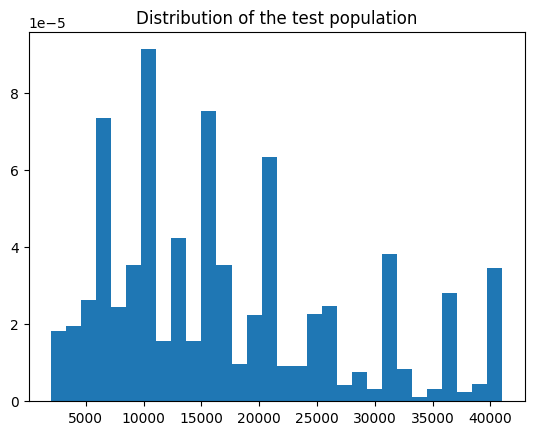

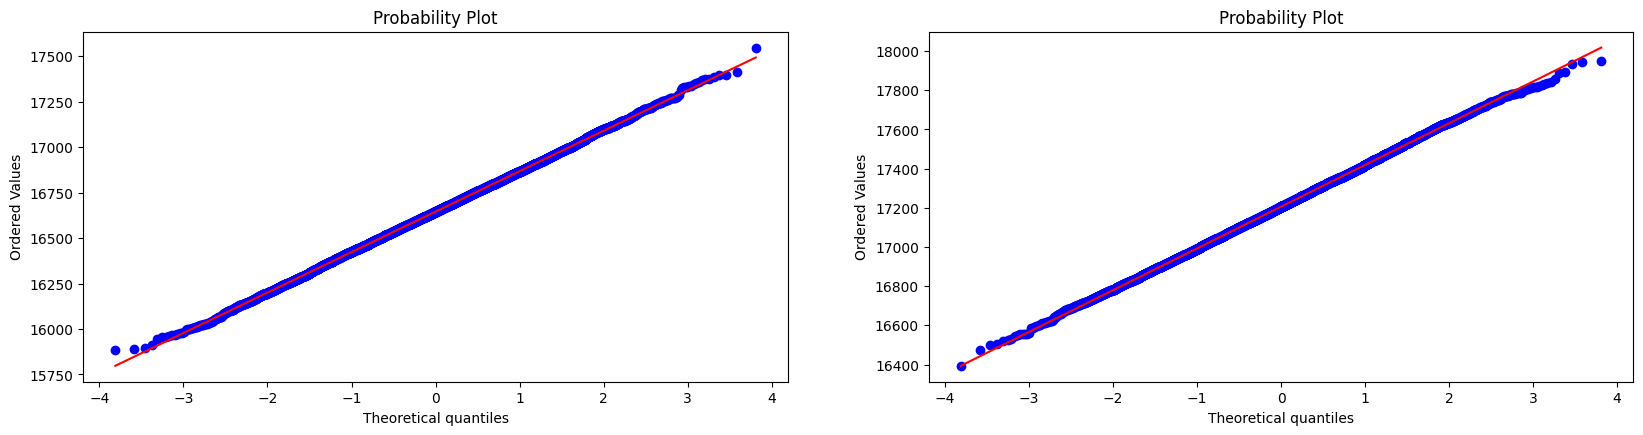

Тест на нормальность распределения control группы: W = 1.000 , p-value = 0.784 => не стат значимо, нормальное
Тест на нормальность распределения target группы: W = 1.000 , p-value = 0.344 => не стат значимо, нормальное


In [27]:
%pylab inline

np.random.seed(42)
sample_means_control = []
sample_means_target = []
for i in range(10000):
    sample_control = control.sample(frac=1, replace=True)
    sample_target = test.sample(frac=1, replace=True)
    sample_means_control.append(sample_control.mean())
    sample_means_target.append(sample_target.mean())
  
# Plot the population
count, bins, ignored = pyplot.hist(sample_control, 30, density=True)
pyplot.title('Distribution of the control population')
pyplot.show()

count, bins, ignored = pyplot.hist(sample_target, 30, density=True)
pyplot.title('Distribution of the test population')
pyplot.show()

# Q-Q plots for control and target groups
pylab.figure(figsize=(20,10))
pylab.subplot(2,2,1)
stats.probplot(sample_means_control, dist="norm", plot=pylab)
pylab.subplot(2,2,2)
stats.probplot(sample_means_target, dist="norm", plot=pylab)
pylab.show()

# check for normality by Shapiro-Wilk test
sp = stats.shapiro(sample_means_control)
concl = '=> не стат значимо, нормальное' if sp[1]>0.05 else '=> стат значимо не нормально' 
print('Тест на нормальность распределения control группы: W = %.3f' % sp[0], ', p-value = %.3f' % sp[1], concl)

sp = stats.shapiro(sample_means_target)
concl = '=> не стат значимо, нормальное' if sp[1]>0.05 else '=> стат значимо не нормально' 
print('Тест на нормальность распределения target группы: W = %.3f' % sp[0], ', p-value = %.3f' % sp[1], concl)


Результат - выборочные средние в тесте и контроле распределены нормально. Мы можем использовать T-тест в нашем эксперименте.

Отдельно отмечу почему я не использую непараметрический критерий Манна-Уитни в рамках этой задачи.  
Т.к мы исследуем изменения среднего значения, то использование критерия Манна-Уитни является некорректным. Данный тест является критерием однородности и не имеет ничего общего с ростом медиан и среднего значения. Следовательно в рамках нашей задачи, мы не сможем корректно сформулировать гипотезы об изменении среднего.

In [35]:
np.random.seed(42)
ttest_ind(test, control, equal_var=False, alternative='greater')

TtestResult(statistic=1.804226479450343, pvalue=0.03563158445406449, df=4465.223694131632)

Как мы видим, p-value < 0.05 и мы могли бы отклонить нулевую гипотезу, но для более точной оценки построим доверительный интервал

In [17]:
cm = CompareMeans(DescrStatsW(test), DescrStatsW(control))
print(cm.tconfint_diff(usevar='unequal'))

(-48.17408141666135, 1160.5763581522688)


Важно отметить, что доверительный интервал включает в себя 0, что означает, что истинная разница между средними может быть и нулевой. Таким образом, хотя p-value меньше установленного уровня значимости и вы можете отклонить нулевую гипотезу о равенстве средних, доверительный интервал указывает на то, что мы не можем быть полностью уверены в том, что среднее тестовой выборки действительно больше среднего из контрольной выборки.

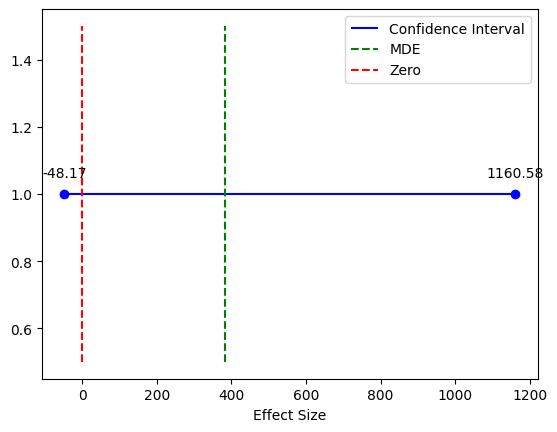

In [18]:
import matplotlib.pyplot as plt

# Значения доверительного интервала
lower_bound = cm.tconfint_diff(usevar='unequal')[0]
upper_bound = cm.tconfint_diff(usevar='unequal')[1]

# Создаем график
fig, ax = plt.subplots()

# Визуализируем доверительный интервал
ax.hlines(1, lower_bound, upper_bound, color='blue', label='Confidence Interval') 

# Визуализируем MDE
ax.vlines(MDE, 0.5, 1.5, color='green', linestyle='--', label='MDE')

# Визуализируем ноль
ax.vlines(0, 0.5, 1.5, color='red', linestyle='--', label='Zero')

# Выделяем крайние точки доверительного интервала и добавляем к ним числовые подписи
ax.scatter([lower_bound, upper_bound], [1, 1], color='blue')
ax.text(lower_bound, 1.05, f'{lower_bound:.2f}', ha='center')
ax.text(upper_bound, 1.05, f'{upper_bound:.2f}', ha='center')

# Добавляем легенду
ax.legend()

# Добавляем подпись к оси X
ax.set_xlabel('Effect Size')

# Показываем график
plt.show()

Стоит провести эксперимент заново с бóльшим количеством наблюдений. Если мы получим более узкий доверительный интервал, то сможем избежать ситуации, когда он включает в себя и значение желаемого эффекта, и 0. Другими словами, мы не попадём в ситуацию, когда тест серый, но при этом гипотезу о том, что эффект равен желаемому, мы также не можем отвергнуть. 